In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler  #标准化
from sklearn.model_selection import train_test_split  #数据集划分
from imblearn.over_sampling import RandomOverSampler #不均衡数据过采样
from sklearn.linear_model import Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit  #交叉验证
from sklearn.model_selection import KFold  #交叉验证
from sklearn.model_selection import GridSearchCV  #模型调参
from sklearn.metrics import make_scorer  #构建模型评估
from sklearn.metrics import mean_absolute_error  #均方误差
from time import clock
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import os
os.chdir(r'F:\项目\津南')

import warnings
warnings.filterwarnings('ignore')

file1 = 'jinnan_round1_train_20181227.csv'

In [2]:
df = pd.read_csv(file1, engine='python')
columns = df.columns.tolist()

# 查看缺失值样本
nan_counts = []
for n in columns:
    df = df.copy()
    nan_count = len(df[n][df[n].isnull()])
    nan_counts.append(nan_count)
    
nan_counts = pd.DataFrame({'nan_counts':nan_counts},
                          index=columns)
describe = nan_counts.describe()
print(nan_counts)

      nan_counts
样本id           0
A1             0
A2          1354
A3            42
A4             0
A5             0
A6             0
A7          1247
A8          1247
A9             0
A10            0
A11            0
A12            0
A13            0
A14            0
A15            0
A16            0
A17            0
A18            0
A19            0
A20            0
A21            3
A22            0
A23            3
A24            1
A25            0
A26            2
A27            0
A28            0
B1            10
B2             2
B3             2
B4             0
B5             1
B6             0
B7             0
B8             1
B9             0
B10          244
B11          849
B12            1
B13            1
B14            0
收率             0


In [3]:
# 分析缺失值异常标签
iqr = describe.loc['75%'] - describe.loc['25%']
max = (describe.loc['75%'] + 3*iqr).values
nan_label = nan_counts[nan_counts.values>max]
print(nan_label)

     nan_counts
A2         1354
A3           42
A7         1247
A8         1247
B1           10
B10         244
B11         849


In [4]:
# 分析各标签正常值范围
def analysis(f):
    describe = f.describe()
    iqr = describe.loc['75%'] - describe.loc['25%']
    max = describe.loc['75%'] + 3*iqr
    min = describe.loc['25%'] - 3*iqr
    print(max, min)
    
analysis(df)

A1      300.000
A2      125.000
A3      405.000
A4      700.000
A6       48.000
A8       80.000
A10     108.000
A12     106.000
A13       0.200
A15     107.000
A17     108.000
A18       0.200
A19     600.000
A21      50.000
A22       9.000
A23       5.000
A27      89.000
B1      360.000
B2        3.500
B3        3.500
B6      125.000
B8       45.000
B12    2400.000
B13       0.150
B14     480.000
收率        1.066
dtype: float64 A1     300.000
A2     125.000
A3     405.000
A4     700.000
A6       6.000
A8      80.000
A10     94.000
A12     99.000
A13      0.200
A15    100.000
A17    101.000
A18      0.200
A19   -100.000
A21     50.000
A22      9.000
A23      5.000
A27     61.000
B1     290.000
B2       3.500
B3       3.500
B6      20.000
B8      45.000
B12   -400.000
B13      0.150
B14    340.000
收率       0.779
dtype: float64


In [5]:
# 分析各标签值统计
# print(df['样本id'].value_counts())

In [6]:
# 对有效标签缺失值填充
df['A3'].fillna(df['A3'].mode().values[0], inplace=True)
df['A8'].fillna(df['A8'].mode().values[0], inplace=True)
df['A21'].fillna(df['A21'].mode().values[0], inplace=True)
df['B1'].fillna(df['B1'].mode().values[0], inplace=True)
df['B2'].fillna(df['B2'].mode().values[0], inplace=True)
df['B8'].fillna(df['B8'].mode().values[0], inplace=True)
df['B12'].fillna(df['B12'].mode().values[0], inplace=True)
df['B13'].fillna(df['B13'].mode().values[0], inplace=True)

In [7]:
# 删除异常值
df = df[df['A17']!=89.0]
df = df[df['A21']<=70.0]
df = df[df['A22']!=3.5]
df = df[df['B1']!=3.5]
df = df[df['B14']!=40.0]

In [8]:
# 筛选标签
df = df[['A1', 'A3', 'A8', 'A10', 'A12', 'A15', 'A17', 'A19', 'A21', 'A22', 'A27', 'B1', 'B2', 'B6', 'B8', 'B12', 'B13', 'B14', '收率']]

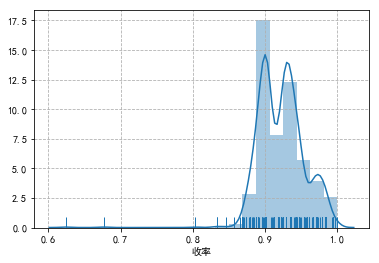

In [9]:
plt.figure(figsize=(6, 4))
sns.distplot(df['收率'], bins = 20, rug=True)
plt.grid(ls='--');

In [10]:
# 标准化
std_scale = StandardScaler()
df_std = std_scale.fit_transform(df)

X = df[['A1', 'A3', 'A8', 'A10', 'A12', 'A15', 'A17', 'A19', 'A21', 'A22', 'A27', 'B1', 'B2', 'B6', 'B8', 'B12', 'B13', 'B14']]
y = df['收率']

In [11]:
# 数据切分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
print('Number transactions train dataset:', X_train.shape[0])
print('Number transactions test dataset:', len(X_test))
print('Number number of transactions:',len(X_train)+len(X_test))

Number transactions train dataset: 1111
Number transactions test dataset: 278
Number number of transactions: 1389


In [12]:
# 过采样
oversampler = RandomOverSampler(random_state=0)
X_train, y_train = oversampler.fit_sample(X_train, y_train)
print(len(X_train))

15687


In [13]:
# 评估
def performance_metric(y_true, y_predict):
    score = mean_absolute_error(y_true, y_predict)
    return score

In [14]:
# 交叉验证
def fit_model_shuffle(X, y, model, *kwargs):
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    model = model
    params = kwargs[0]
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(model, param_grid=params, scoring=scoring_fnc, cv=cv_sets)
    grid = grid.fit(X, y)
    return grid.best_estimator_


# def fit_model_k_fold(X, y, model, *kwargs):
#     k_fold = KFold(n_splits=10)
#     model = model
#     params = kwargs[0]
#     scoring_fnc = make_scorer(performance_metric)
#     grid = GridSearchCV(model, param_grid=params, scoring=scoring_fnc, cv=k_fold)
#     grid = grid.fit(X, y)
#     return grid.best_estimator_

In [15]:
ls = Lasso()
rd = Ridge()
en = ElasticNet()
br = BayesianRidge()
dtr = DecisionTreeRegressor()
svr = SVR()
knn = KNeighborsRegressor()
rf = RandomForestRegressor()
ada = AdaBoostRegressor()
gbrt = GradientBoostingRegressor()

In [16]:
# 训练各种模型
start = clock()
ls = fit_model_shuffle(X_train, y_train, ls, {'max_iter':[1, 10, 100], 'alpha':[0.01, 0.1, 1]})
end = clock()
delta = end - start
print(ls)
print('共计耗时', delta)
print()

start = clock()
rd = fit_model_shuffle(X_train, y_train, rd, {'alpha':[100, 110, 120, 130]})
end = clock()
delta = end - start
print(rd)
print('共计耗时', delta)
print()

start = clock()
en = fit_model_shuffle(X_train, y_train, en,{'l1_ratio':[0.9, 0.95, 1], 'max_iter':[100, 300, 500]})
end = clock()
delta = end - start
print(en)
print('共计耗时', delta)
print()

start = clock()
br = fit_model_shuffle(X_train, y_train, br, {'alpha_1':[0.000001, 0.0001, 0.001, 0.01], 'alpha_1':[0.000001, 0.0001, 0.001, 0.01]})
end = clock()
delta = end - start
print(br)
print('共计耗时', delta)
print()

start = clock()
dtr = fit_model_shuffle(X_train, y_train, dtr, {'min_samples_split':[2, 4, 6, 8, 10]})
end = clock()
delta = end - start
print(dtr)
print('共计耗时', delta)
print()

start = clock()
svr = fit_model_shuffle(X_train, y_train, svr, {'degree':[1, 2, 3, 4, 5], 'cache_size':[100, 200, 300]})
end = clock()
delta = end - start
print(svr)
print('共计耗时', delta)
print()

start = clock()
knn = fit_model_shuffle(X_train, y_train, knn, {'n_neighbors':range(1, 20)})
end = clock()
delta = end - start
print(knn)
print('共计耗时', delta)
print()

start = clock()
rf = fit_model_shuffle(X_train, y_train, rf, {'n_estimators':[15, 20, 25]})
end = clock()
delta = end - start
print(rf)
print('共计耗时', delta)
print()

start = clock()
ada = fit_model_shuffle(X_train, y_train, ada, {'n_estimators':[40, 50, 60]})
end = clock()
delta = end - start
print(ada)
print('共计耗时', delta)
print()

start = clock()
gbrt = fit_model_shuffle(X_train, y_train, gbrt, {'n_estimators':[80, 100, 120]})
end = clock()
delta = end - start
print('共计耗时', delta)
print(gbrt)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1, normalize=False,
   positive=False, precompute=False, random_state=None, selection='cyclic',
   tol=0.0001, warm_start=False)
共计耗时 0.6423816550000003

Ridge(alpha=110, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
共计耗时 0.22937085499999998

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=1,
      max_iter=100, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
共计耗时 0.5691577999999997

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
共计耗时 0.40638761499999987

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, m

In [17]:
# 各模型比较

def min(X, y, regs):
    maes = dict()
    n = 0
    for reg in regs:
        mae = performance_metric(y, reg.predict(X))
        lists = ['ls', 'rd', 'en', 'br', 'dtr', 'svr', 'knn', 'rf', 'ada', 'gbrt']
        maes[lists[n]] = mae
        n += 1
    f = zip(maes.values(), maes.keys())
    return sorted(f)

In [18]:
lists = [ls, rd, en, br, dtr, svr, knn, rf, ada, gbrt]
print('最优模型是:{}, 均方差为:{}'.format(min(X_test, y_test, lists)[0][1], min(X_test, y_test, lists)[0][0]))

最优模型是:rf, 均方差为:0.014576846276191751
